In [ ]:
import os
import shutil
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet101
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf

# Path ke direktori dataset train
train_dir = '/content/drive/MyDrive/datasetUAP/train'

# Memuat dataset dari direktori train
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'  # Menggunakan label numerik untuk klasifikasi
)

# Mendapatkan nama-nama kelas dari dataset train
class_names = train_dataset.class_names

# Menampilkan nama-nama kelas
print(f"Class names: {class_names}")


Found 25925 files belonging to 11 classes.
Class names: ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']


In [ ]:
# Hitung jumlah gambar dalam setiap kelas
data_distribution = {}
for class_name in class_names:
    class_dir = os.path.join(base_dir, class_name)
    total_images = len([f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.jpeg', '.JPG'))])
    data_distribution[class_name] = total_images

# Tampilkan hasil
for class_name, count in data_distribution.items():
    print(f"{class_name}: {count} images")

def count_total_images(directory):
    total_images = 0
    for root, dirs, files in os.walk(directory):
        total_images += len(files)  # Jumlah file di setiap subfolder
    return total_images

total_images = count_total_images(base_dir)
print(f"\nTotal jumlah citra di dataset: {total_images}")


Bacterial_spot: 2836 images
Early_blight: 2455 images
Late_blight: 3117 images
Leaf_Mold: 2754 images
Septoria_leaf_spot: 2908 images
Spider_mites Two-spotted_spider_mite: 1747 images
Target_Spot: 1827 images
Tomato_Yellow_Leaf_Curl_Virus: 2036 images
Tomato_mosaic_virus: 2171 images
healthy: 3060 images
powdery_mildew: 1014 images

Total jumlah citra di dataset: 25925


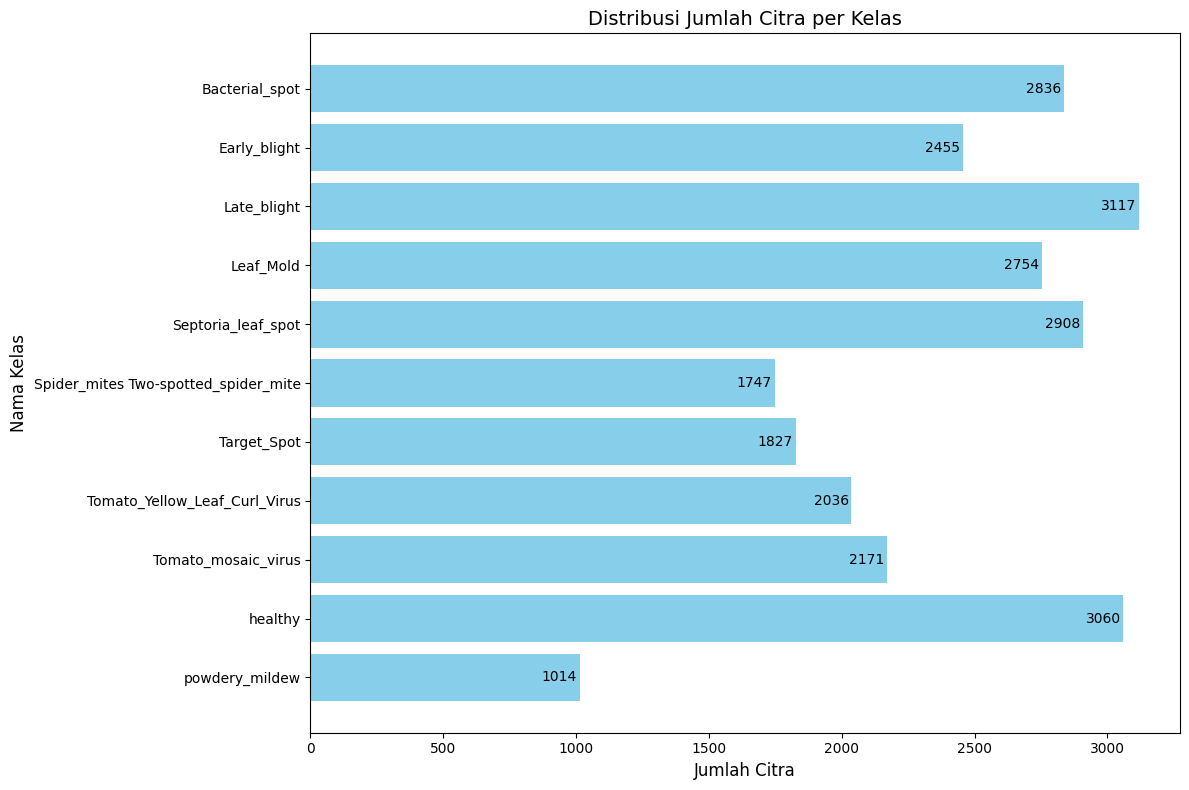

In [ ]:
# Visualisasi dengan Bar Plot Horizontal
fig, ax = plt.subplots(figsize=(12, 8))
class_names_list = list(data_distribution.keys())
image_counts = list(data_distribution.values())

# Membuat bar plot horizontal
bars = ax.barh(class_names_list, image_counts, color='skyblue')

# Menambahkan label nilai di setiap batang
for bar in bars:
    ax.text(bar.get_width() - 10, bar.get_y() + bar.get_height()/2,
            str(int(bar.get_width())), va='center', ha='right', fontsize=10, color='black')

# Menata tampilan plot
ax.set_title("Distribusi Jumlah Citra per Kelas", fontsize=14)
ax.set_xlabel("Jumlah Citra", fontsize=12)
ax.set_ylabel("Nama Kelas", fontsize=12)
ax.invert_yaxis()  # Membalik sumbu Y agar urutan rapi

plt.tight_layout()
plt.show()

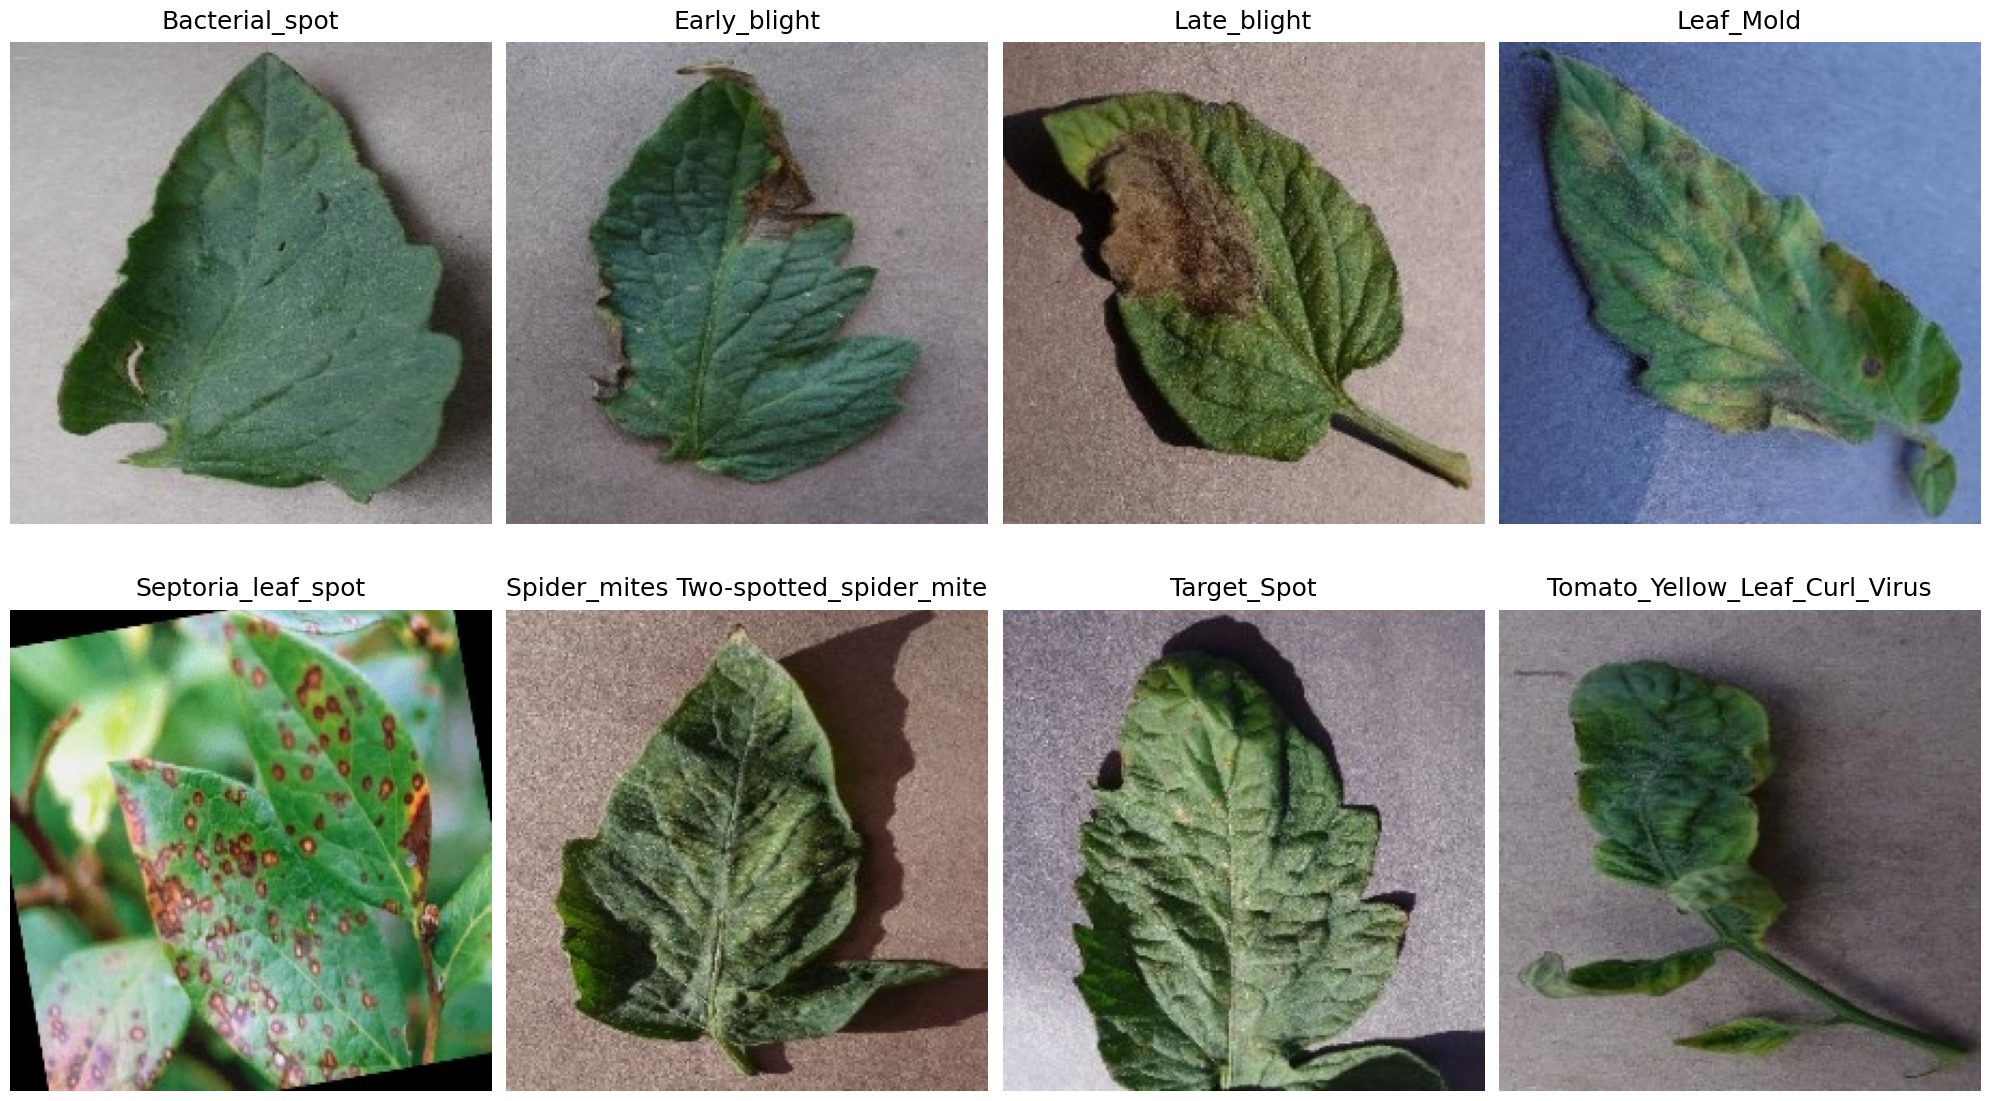

In [ ]:
images = []

for leaf_dir in class_names:
    leaf_items = os.listdir(os.path.join(base_dir, leaf_dir))

    if leaf_items:
      selected_images = np.random.choice(leaf_items)
      images.append(os.path.join(base_dir, leaf_dir, selected_images))

# Visualization
num_images = len(images)  # Get the total number of images
num_rows = 2  # Number of rows in the subplot grid
num_cols = 4  # Number of columns in the subplot grid

# Calculate the total number of subplots needed
num_subplots = num_rows * num_cols

# Limit the number of images to display to the available subplots
num_images_to_display = min(num_images, num_subplots)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 12))  # Create subplots

for subplot, image_ in enumerate(images[:num_images_to_display]): # Iterate through images to display
    category = image_.split("/")[-2]
    imgs = plt.imread(image_)

    row = subplot // num_cols  # Calculate row index
    col = subplot % num_cols  # Calculate column index

    ax = axes[row, col]  # Get the current subplot
    ax.imshow(imgs)
    ax.set_title(category, pad=10, size=18)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
split_dir = '/content/drive/MyDrive/datasetUAP/train_split'

# Buat direktori baru untuk split dataset
train_dir = os.path.join(split_dir, 'train')
val_dir = os.path.join(split_dir, 'validation')
test_dir = os.path.join(split_dir, 'test')

for folder in [train_dir, val_dir, test_dir]:
    if not os.path.exists(folder):
        os.makedirs(folder)

# Proporsi split
train_split = 0.8
val_split = 0.1
test_split = 0.1

# Use base_dir instead of augmented_dir
# base_dir should contain the path to your resized images
base_dir = '/content/drive/MyDrive/datasetUAP/train_resize'

for class_name in class_names:
    class_path = os.path.join(base_dir, class_name) # Changed to base_dir
    images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png', '.JPEG'))]
    random.shuffle(images)  # Acak urutan gambar

    train_count = int(len(images) * train_split)
    val_count = int(len(images) * val_split)

    # Alokasikan gambar ke train, validation, dan test
    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]

    # Buat subfolder per kelas
    for subfolder, img_list in zip(['train', 'validation', 'test'],
                                   [train_images, val_images, test_images]):
        target_dir = os.path.join(split_dir, subfolder, class_name)
        os.makedirs(target_dir, exist_ok=True)

        for img_name in img_list:
            src = os.path.join(class_path, img_name)
            dst = os.path.join(target_dir, img_name)
            shutil.copy2(src, dst)

print("Split data selesai.")

Split data selesai.


In [ ]:
train_dir = '/content/drive/MyDrive/datasetUAP/train_split/train'
val_dir = '/content/drive/MyDrive/datasetUAP/train_split/validation'
test_dir = '/content/drive/MyDrive/datasetUAP/train_split/test'

In [ ]:
import tensorflow as tf

split_dir = '/content/drive/MyDrive/datasetUAP/train_split'

image_size = (224, 224)
batch_size = 32

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print(f"Training data: {train_data.samples} images")
print(f"Validation data: {val_data.samples} images")
print(f"Testing data: {test_data.samples} images")


Found 5420 images belonging to 11 classes.
Found 674 images belonging to 11 classes.
Found 687 images belonging to 11 classes.
Training data: 5420 images
Validation data: 674 images
Testing data: 687 images


In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(train_data.class_indices), activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

# Membekukan layer MobileNet (opsional, bisa fine-tuning nanti)
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,423,371 (9.24 MB)

 Trainable params: 165,387 (646.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


170/170 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.1197 - loss: 2.8712 - val_accuracy: 0.2211 - val_loss: 2.1917
Epoch 2/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.1993 - loss: 2.3888 - val_accuracy: 0.2923 - val_loss: 1.9741
Epoch 3/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.2299 - loss: 2.2245 - val_accuracy: 0.3531 - val_loss: 1.8402
Epoch 4/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - accuracy: 0.2694 - loss: 2.1120 - val_accuracy: 0.4006 - val_loss: 1.7412
Epoch 5/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.2959 - loss: 1.9770 - val_accuracy: 0.4421 - val_loss: 1.6627
Epoch 6/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.3253 - loss: 1.9333 - val_accuracy: 0.4807 - val_loss: 1.5964
Epoch 7/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - accuracy: 0.3511 - loss: 1.8337 - val_accuracy: 0.5030 - val_loss: 1.5383
Epoch 8/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.3691 - loss: 1.7924 - val_accuracy: 0.526

In [ ]:
test_loss, test_acc = model.evaluate(test_data, verbose=2)
print(f"\nAkurasi model pada data test: {test_acc:.2f}")

22/22 - 33s - 1s/step - accuracy: 0.5633 - loss: 1.2214

Akurasi model pada data test: 0.56


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data.classes

# Get unique labels from true_classes
unique_labels = np.unique(true_classes)

# Ensure that class_labels contains all the unique labels and in the same order
class_labels = [label for label in test_data.class_indices.keys() if int(test_data.class_indices[label]) in unique_labels]

# Print to verify the number of classes and labels
num_classes = len(unique_labels)
print(f"Number of unique classes in true_classes: {num_classes}")
print(f"Number of class labels: {len(class_labels)}")

# If there's still a mismatch, you can try adjusting predicted_classes
# For example, to remap predicted_classes to the correct labels:
# label_mapping = {v: k for k, v in test_data.class_indices.items()}
# predicted_classes = [label_mapping[pred] for pred in predicted_classes]

report = classification_report(true_classes, predicted_classes, target_names=class_labels, labels=unique_labels)
print("Classification Report:")
print(report)

22/22 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step
Number of unique classes in true_classes: 10
Number of class labels: 10
Classification Report:
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.52      0.46      0.49       105
                        Early_blight       0.40      0.07      0.12        29
                         Late_blight       0.47      0.67      0.55       123
                           Leaf_Mold       0.60      0.25      0.35        60
                  Septoria_leaf_spot       0.44      0.37      0.40       113
Spider_mites Two-spotted_spider_mite       0.00      0.00      0.00         2
       Tomato_Yellow_Leaf_Curl_Virus       0.00      0.00      0.00         8
                 Tomato_mosaic_virus       0.55      0.62      0.58        37
                             healthy       0.77      0.94      0.84       112
                      powdery_mildew       0.59      0.71      0.65        98

      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


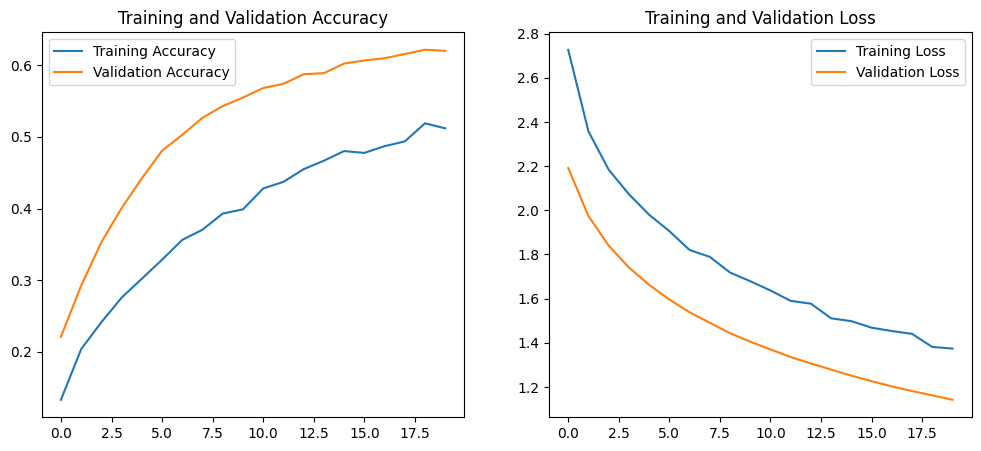

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

22/22 - 33s - 2s/step


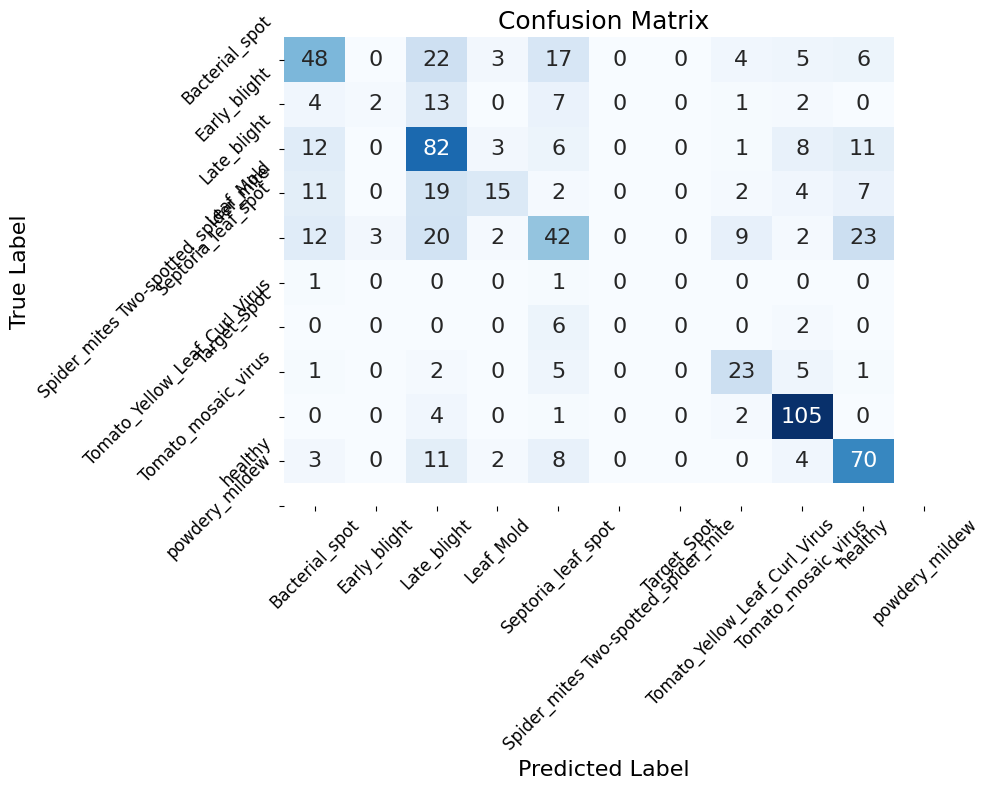

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_pred = model.predict(test_data, verbose=2)
test_pred_class = np.argmax(test_pred, axis=1)
test_true_class = test_data.classes
cm = confusion_matrix(test_true_class, test_pred_class)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys(), cbar=False, annot_kws={'size': 16})
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

22/22 - 38s - 2s/step


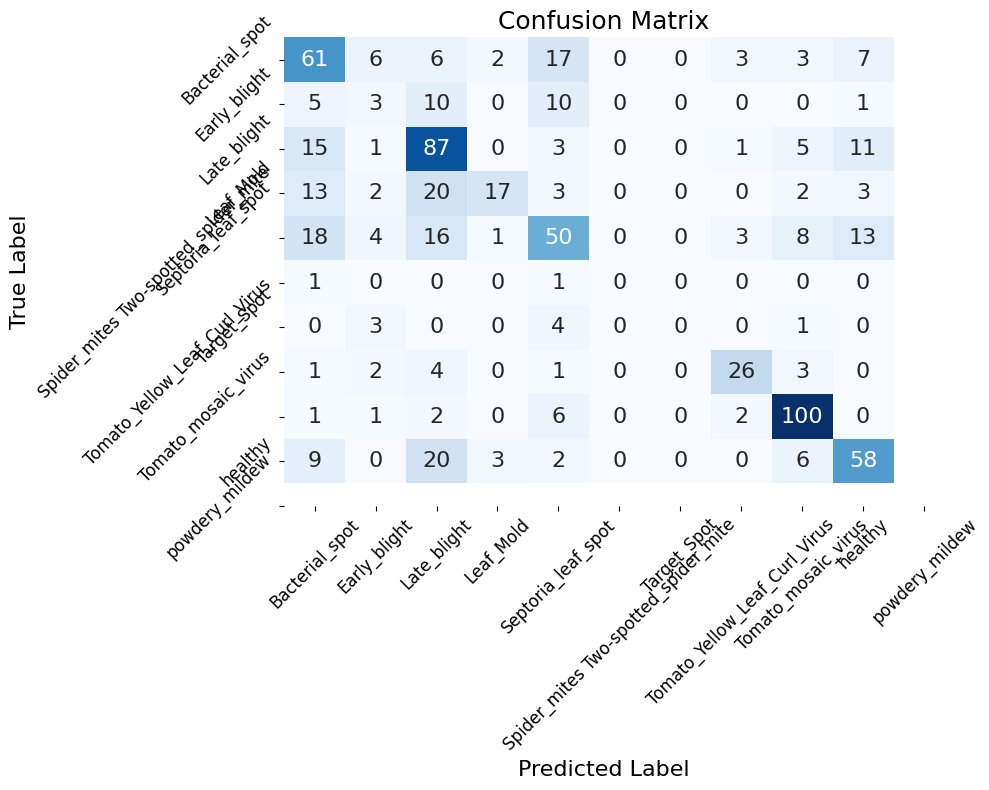

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_pred = model.predict(test_data, verbose=2)
test_pred_class = np.argmax(test_pred, axis=1)
test_true_class = test_data.classes
cm = confusion_matrix(test_true_class, test_pred_class)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys(), cbar=False, annot_kws={'size': 16})
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
model.save("UAP_MobileNet.keras")